제시된 여행 보험 예측 데이터에서 TravelInsurance(여행보험 패키지를 구매 했는지 여부) 를 예측하는 모델을 개발하고
모델 개발 과정과 테스트 데이터셋에 대한 auc 를 답안으로 작성하시오

In [293]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [238]:
df = pd.read_csv("./data/travel_insurance_prediction.csv")

In [239]:
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [240]:
df.info()
# 결측값은 없음
# 오브젝트는 분석을 통해 인코딩 또는 드랍여부 판단

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


In [241]:
df.describe()
# 데이터간 크기가 상이하므로 스케일링이 필요

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


In [242]:
df["Employment Type"].value_counts()

Employment Type
Private Sector/Self Employed    1417
Government Sector                570
Name: count, dtype: int64

In [243]:
df["GraduateOrNot"].value_counts()

GraduateOrNot
Yes    1692
No      295
Name: count, dtype: int64

In [244]:
df["FrequentFlyer"].value_counts()

FrequentFlyer
No     1570
Yes     417
Name: count, dtype: int64

In [245]:
df["EverTravelledAbroad"].value_counts()

EverTravelledAbroad
No     1607
Yes     380
Name: count, dtype: int64

<Axes: >

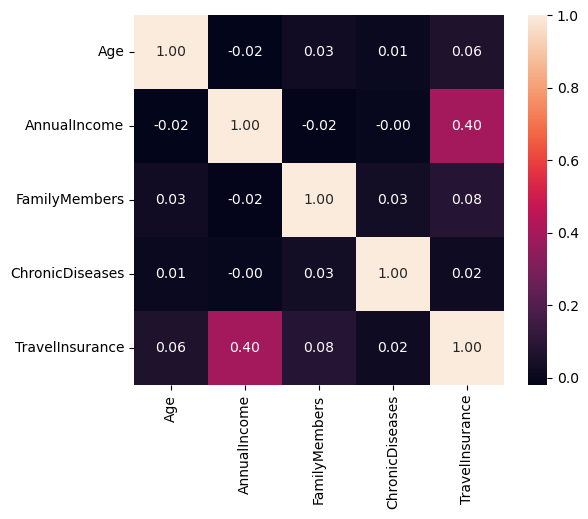

In [247]:
df_corr = df.corr(numeric_only=True)
sns.heatmap(
    df_corr,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=df_corr,
    xticklabels=df_corr,
)

- AnnualIncome 의 영향이 가장 큼

In [ ]:
# 인코딩할 컬럼들 이름 가져오기
object_columns = df.select_dtypes(include="object").columns.tolist()

In [ ]:
object_columns_reshape = np.reshape(object_columns, (-1, 1))

for column in object_columns_reshape:
    ohe = OneHotEncoder()
    ohe_arr = np.array(df[column])
    ohe_arr = np.reshape(ohe_arr, (-1, 1))

    ohe_name = ohe.fit_transform(ohe_arr)
    ohe_df = pd.DataFrame(
        ohe_name.toarray(), columns=ohe.get_feature_names_out(input_features=column)
    )
    df = pd.concat([df, ohe_df], axis=1)

In [ ]:
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,31,Government Sector,Yes,400000,6,1,No,No,0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [ ]:
x = df.drop("TravelInsurance", axis=1)
y = df["TravelInsurance"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify=df[object_columns], random_state=3056
)

In [ ]:
x_train.shape, x_test.shape

((1490, 16), (497, 16))

In [ ]:
x_train.drop(object_columns, axis=1, inplace=True)
x_test.drop(object_columns, axis=1, inplace=True)

In [ ]:
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train)
scaled_test = ss.transform(x_test)

# 의사결정나무

In [296]:
dt = DecisionTreeClassifier(random_state=3056)
dt.fit(scaled_train, y_train)
print(dt.score(scaled_train, y_train))
print(dt.score(scaled_test, y_test))

0.925503355704698
0.7625754527162978


In [270]:
scores = cross_validate(
    dt,
    scaled_train,
    y_train,
    return_train_score=True,
    n_jobs=-1,
    cv=8,
    scoring="roc_auc",
)

print(np.mean(scores["train_score"]))
print(np.mean(scores["test_score"]))

0.9862896929350611
0.7410137250749973


# 랜덤포레스트

In [294]:
rf = RandomForestClassifier(
    n_estimators=300, oob_score=True, n_jobs=-1, random_state=3056
)

In [295]:
scores = cross_validate(
    rf,
    scaled_train,
    y_train,
    return_train_score=True,
    n_jobs=-1,
    cv=8,
    scoring="roc_auc",
)

print(np.mean(scores["train_score"]))
print(np.mean(scores["test_score"]))

0.9840562656300115
0.7906657899748266


# 엑스트라 트리

In [297]:
et = ExtraTreesClassifier(n_jobs=-1, random_state=3056)
scores = cross_validate(
    et,
    scaled_train,
    y_train,
    return_train_score=True,
    n_jobs=-1,
    cv=8,
    scoring="roc_auc",
)

print(np.mean(scores["train_score"]))
print(np.mean(scores["test_score"]))

0.9862896929350611
0.7684320491976975


# 그레디언트 부스팅

In [288]:
gb = GradientBoostingClassifier(random_state=3056, n_estimators=300, learning_rate=0.09)

scores = cross_validate(
    gb,
    scaled_train,
    y_train,
    return_train_score=True,
    n_jobs=-1,
    cv=8,
    scoring="roc_auc",
)

print(np.mean(scores["train_score"]))
print(np.mean(scores["test_score"]))

0.9273214485957529
0.8181094993950637


In [290]:
gb.fit(scaled_train, y_train)

GradientBoostingClassifier(learning_rate=0.09, n_estimators=300,
                           random_state=3056)

In [292]:
gb.feature_importances_

array([0.11988783, 0.63925501, 0.18763464, 0.01682369, 0.0041646 ,
       0.00286495, 0.00559019, 0.01006204, 0.00461397, 0.00549999,
       0.00150406, 0.00209904])

# 로지스틱 회귀

In [313]:
logi = LogisticRegression()
scores = cross_validate(
    logi,
    scaled_train,
    y_train,
    return_train_score=True,
    n_jobs=-1,
    cv=300,
    scoring="roc_auc",
)

print(np.mean(scores["train_score"]))
print(np.mean(scores["test_score"]))

0.7699833551424886
0.7727777777777778
